# Model Dependency Analysis Using SHAP: Center Model

The task here is to analyze partial dependency of the trained Cinger model using SHAP(SHapley Additive exPlanations).

In [10]:
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

shap.initjs()

# Load Data

In [11]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

centers = data[data['POSITION'].isin(['r', 'l', 'l, r'])].copy()

# Select only players with 41 or more games played
centers_41GP = centers[(centers['GP'] >= 41)].copy()
test_train_data = centers_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Load in the pipeline using joblib

pipeline = joblib.load('Center_Model/center_salary_pipeline.pkl')

/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarni

In [13]:
# Make predictions (this part seems fine)
y_pred = pipeline.predict(X_test)

# get rfecv from pipeline
rfecv = pipeline.named_steps['selector']

# Now, for SHAP values, we need to ensure we only consider features that were kept after RFECV
# Extract the support mask from RFECV to identify selected features
selected_features = rfecv.get_support(indices=True)
selected_feature_names = [numerical_features[i] for i in selected_features]

# Apply transformation only on selected features
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)[:, selected_features]

# Now, create a DataFrame with correctly selected features for SHAP
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=selected_feature_names, index=X_test.index)

# Proceed with SHAP explainer
explainer = shap.Explainer(pipeline.named_steps['regressor'].get_booster())  # Ensure to get the underlying booster for SHAP
shap_values = explainer(X_test_transformed_df)  # This should now align with expected dimensions

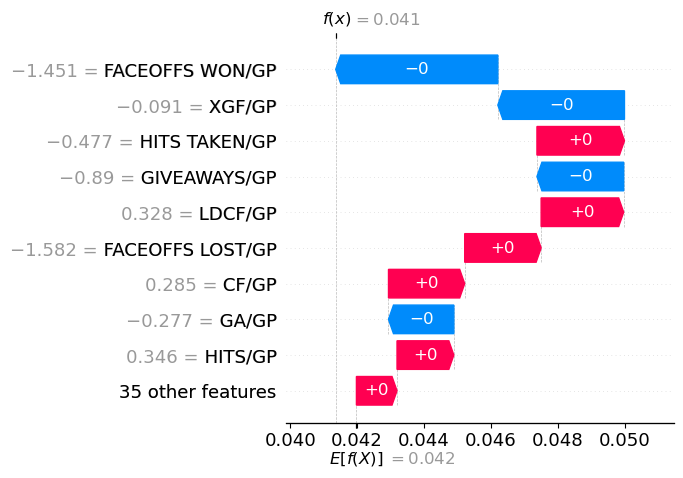

In [14]:
fig = plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.gcf().set_size_inches(5,5)
plt.show()

In [15]:
# Access the trained XGBRegressor model from the pipeline
xgb_model = pipeline.named_steps['regressor']

# Retrieve the feature importances
feature_importances = xgb_model.feature_importances_

# Assuming 'numerical_features' holds the original names of the features prior to fitting
# and we are also taking into account that some features might have been dropped by the RFECV step
selected_features = numerical_features[rfecv.support_]

# Combine feature names and their importance scores in a dictionary
feature_importance_dict = dict(zip(selected_features, feature_importances))

# Sort the dictionary by importance scores in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: FF/GP, Importance: 0.2702122926712036
Feature: CF/GP, Importance: 0.25098586082458496
Feature: XGF/GP, Importance: 0.09733951091766357
Feature: SF/GP, Importance: 0.042494237422943115
Feature: FACEOFFS WON/GP, Importance: 0.019550595432519913
Feature: LDCF/GP, Importance: 0.016672126948833466
Feature: FA/GP, Importance: 0.01448819600045681
Feature: HITS TAKEN/GP, Importance: 0.014357324689626694
Feature: GIVEAWAYS/GP, Importance: 0.013258606195449829
Feature: SA/GP, Importance: 0.011971035040915012
Feature: MDCF/GP, Importance: 0.011018587276339531
Feature: IFF/GP, Importance: 0.01085430383682251
Feature: SCA/GP, Importance: 0.01046905666589737
Feature: HDGF/GP, Importance: 0.010379564948379993
Feature: HDCF/GP, Importance: 0.009266323409974575
Feature: CA/GP, Importance: 0.009221961721777916
Feature: LDCA/GP, Importance: 0.008665366098284721
Feature: MDCA/GP, Importance: 0.008634650148451328
Feature: SHOTS BLOCKED/GP, Importance: 0.008208156563341618
Feature: MDGF/GP, Importa

In [16]:
shap.plots.force(shap_values[0])

In [17]:
shap.plots.force(shap_values[:100])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

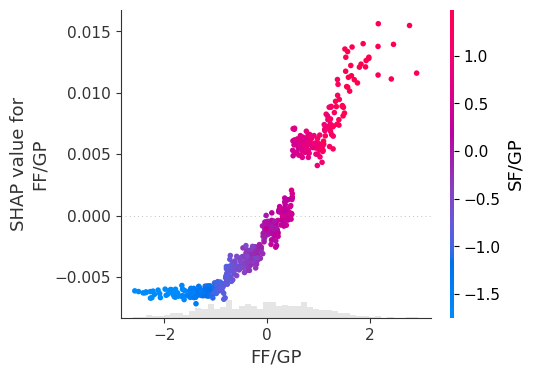

In [19]:
fig = plt.figure()
shap.plots.scatter(shap_values[:, "FF/GP"], color=shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()

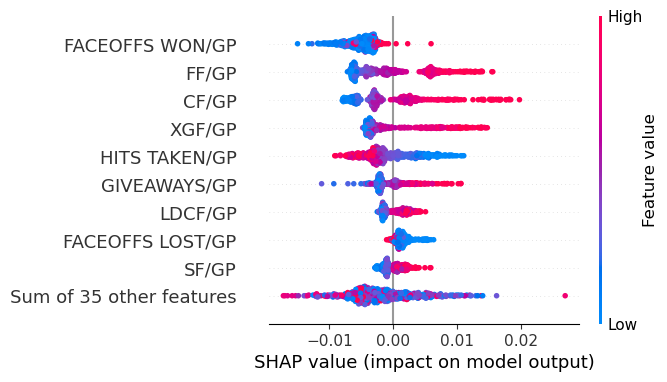

In [20]:
fig = plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()

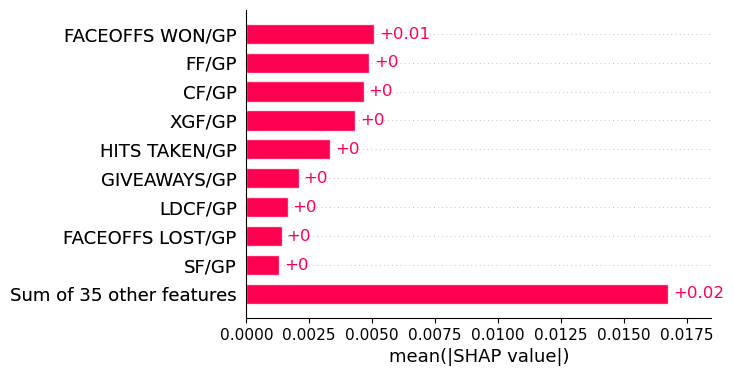

In [22]:
fig = plt.figure()
shap.plots.bar(shap_values, show=False)
plt.gcf().set_size_inches(6,4)
plt.show()